## Problem Statement

### Context


AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries and data

In [68]:
# this will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Data Overview

- Observations
- Sanity checks

In [69]:
from google.colab import drive
drive.mount('/content/drive')

url = "/content/drive/MyDrive/unsupervised learning/CreditCardCustomerData.csv"
data = pd.read_csv(url)
df = data.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [71]:
df.shape

(660, 7)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [73]:
df.duplicated().value_counts()

False    660
dtype: int64

In [74]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

* Data contains 660 rows and 7 columns
* All columns are numerical
* There are no duplicate rows
* There are no missing values in the dataset.
* Sl_No column is essentially an index column and can be dropped, it is not useful for analysis
* There are duplicate values in Customer Key column.

In [75]:
cust_key_counts = df['Customer Key'].value_counts()
dupl_cust = cust_key_counts[cust_key_counts.values >= 2].index

In [76]:
df[df['Customer Key'].isin(dupl_cust)].sort_values('Customer Key')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


* The data for duplicated customer keys is completely different. Duplicated customer keys are probably data entry errors. We will not remove these rows from the data set.
* The Customer Key column contains customer identifier and can be dropped without affecting analysis.

In [77]:
df.drop(columns=['Sl_No', 'Customer Key'], inplace=True)

In [78]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


* Average customer has 4-5 credit cards, has a credit limit of approximately 34.5K, and interracts with bank employees (through calls or in-person visits) about 6 times a year.
* Values in Avg_Credit_Limit are much larger than the values in other columns. We will need to scale the data before applying clustering algorithms.

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Questions

1. How is the distrubution of average credit limit of customer?
2. What percenatage of the customers have never made a service-related call to the bank?
3. What percentage of customers have never logged in to the online portal?
4. How many customers have never visited bank?
3. How are the different variables correlated with each other?

#### Helper Functions

In [79]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [80]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

#### Avg_Credit_Limit: Average credit limit of each customer for all credit cards




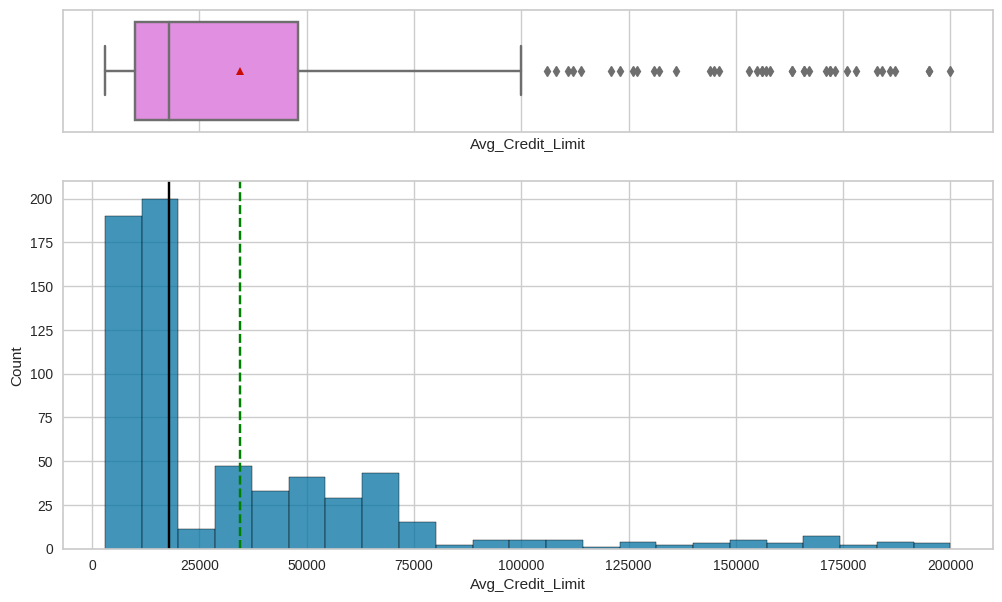

In [81]:
histogram_boxplot(data, "Avg_Credit_Limit", figsize=(12, 7), kde=False, bins=None)

In [82]:
df["Avg_Credit_Limit"].describe()

count       660.000000
mean      34574.242424
std       37625.487804
min        3000.000000
25%       10000.000000
50%       18000.000000
75%       48000.000000
max      200000.000000
Name: Avg_Credit_Limit, dtype: float64

 * This is a right skewed distribution
 * This column contains a lot of outliers at the right end.
 * Credit limits range from 3K to 200K
 * 50% of the customers have credit limits under 18K

#### Total_Credit_Cards: Total number of credit cards possessed by the customer


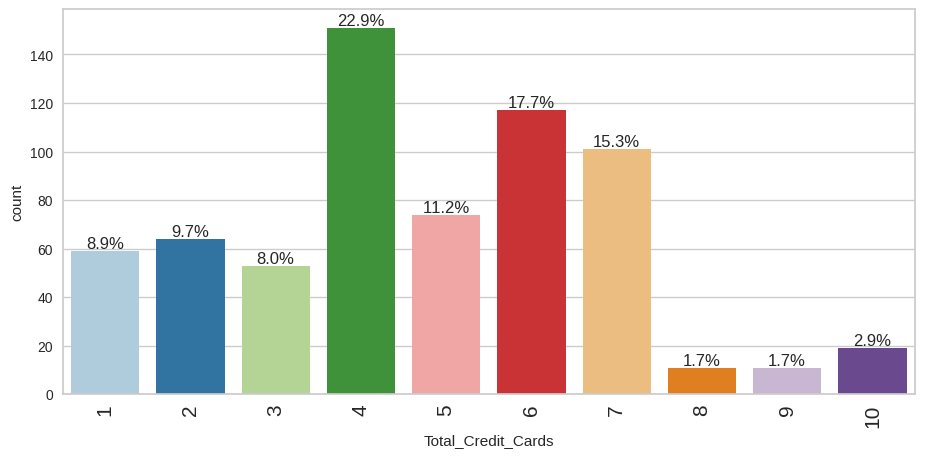

In [83]:
labeled_barplot(data, "Total_Credit_Cards", perc=True, n=None)

* Customers with 4 credit cards is the most frequently occuring category ( \~23% ), followed by customers with six (\~18%) and seven (~15%) credit cards.
* Maximum number of credit cards in the dataset is 10
* Customers with only one credit card account for ~9% of the data.

#### Total visits bank: Total number of Visits that customer made (yearly) personally to the bank


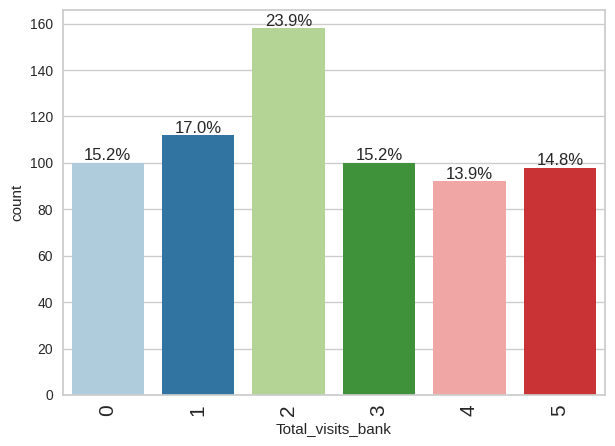

In [84]:
labeled_barplot(data, "Total_visits_bank", perc=True, n=None)

* Number of in-person bank visits ranges from 0 to 5 visits per year
* 15% of the customers have not visited bank in person.
* ~24% of the customers visited bank twice per year. This is the most commonly occuring category.

#### Total visits online: Total number of visits or online logins made by the customer (yearly)


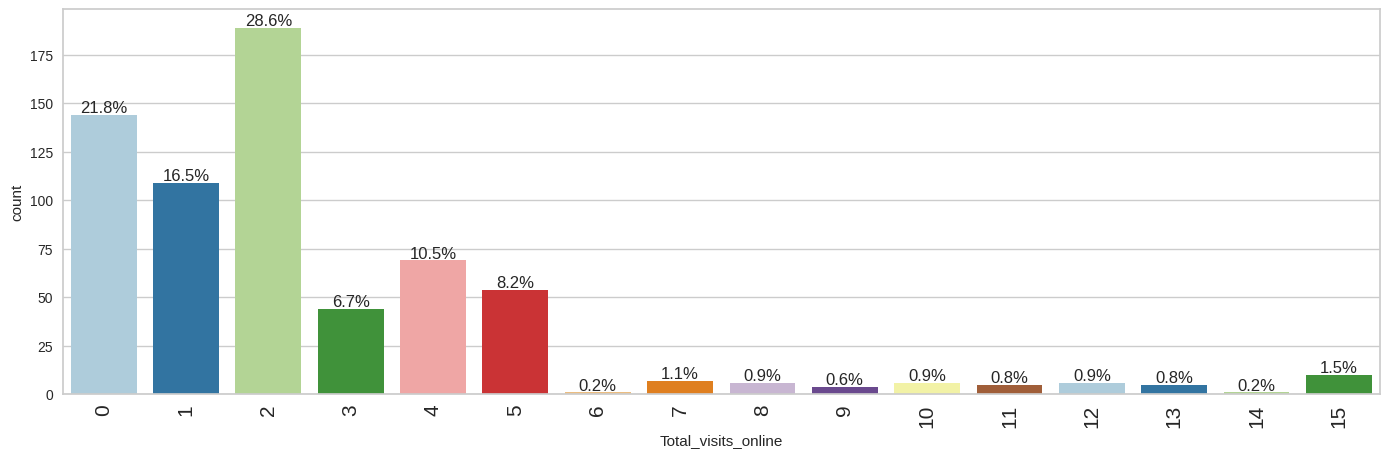

In [85]:
labeled_barplot(data, "Total_visits_online", perc=True, n=None)

* Number of online visits ranges from 0 to 15 visits a year
* About 22% of the customers have never logged in to the online portal.
* Most of the customers interact with online portal not more than 5 times per year.
* 2 online visits per year is the most common category, and accounts for almost 30% of the data.

#### Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

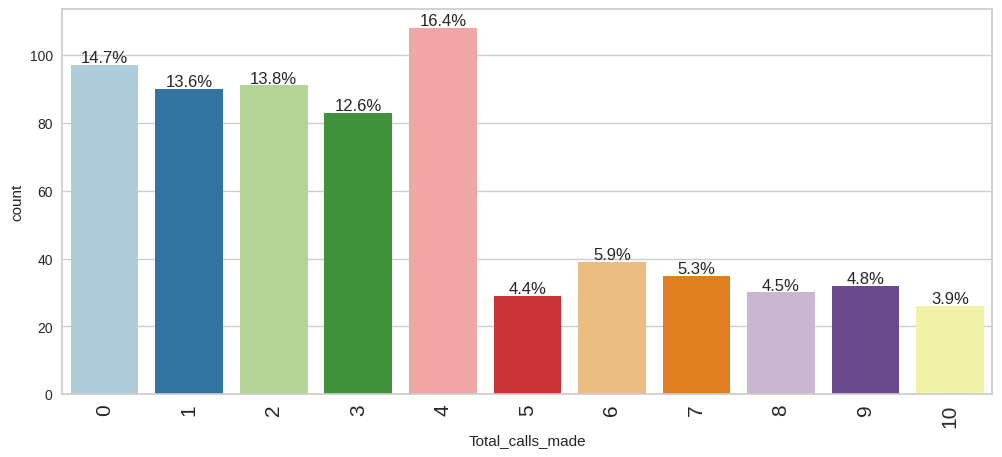

In [86]:
labeled_barplot(data, "Total_calls_made", perc=True, n=None)

* Total number of calls ranges from 0 to 10 calls a year
* About 15% of customers never made a service-related call to the bank.
* Most frequently occuring category is 4 calls, which accounts for about 16% of the data.

### Bi-variate Analysis

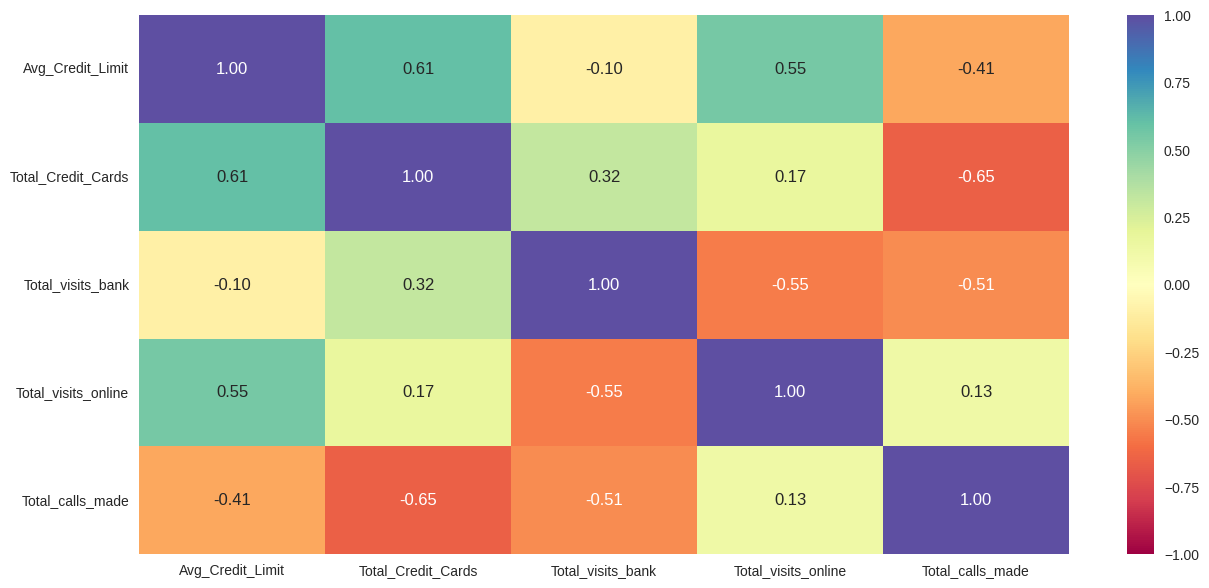

In [87]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

* Average Credit Limit is moderately positively correlated with Number of Online Visits, and moderately negatively correlated with Number of Calls Made.
* Total number of credit cards is  strongly positively correlated with Average Credit Limit.
* Total number of credit cards is  strongly negatively correlated with Total number of calls made by the customer to the bank.
* Total number of in-person visits to the bank is moderately negatively correlated with number of calls or online visits a customer makes per year.
* Number of calls is moderately negatively correlated with Average Credit Limit.


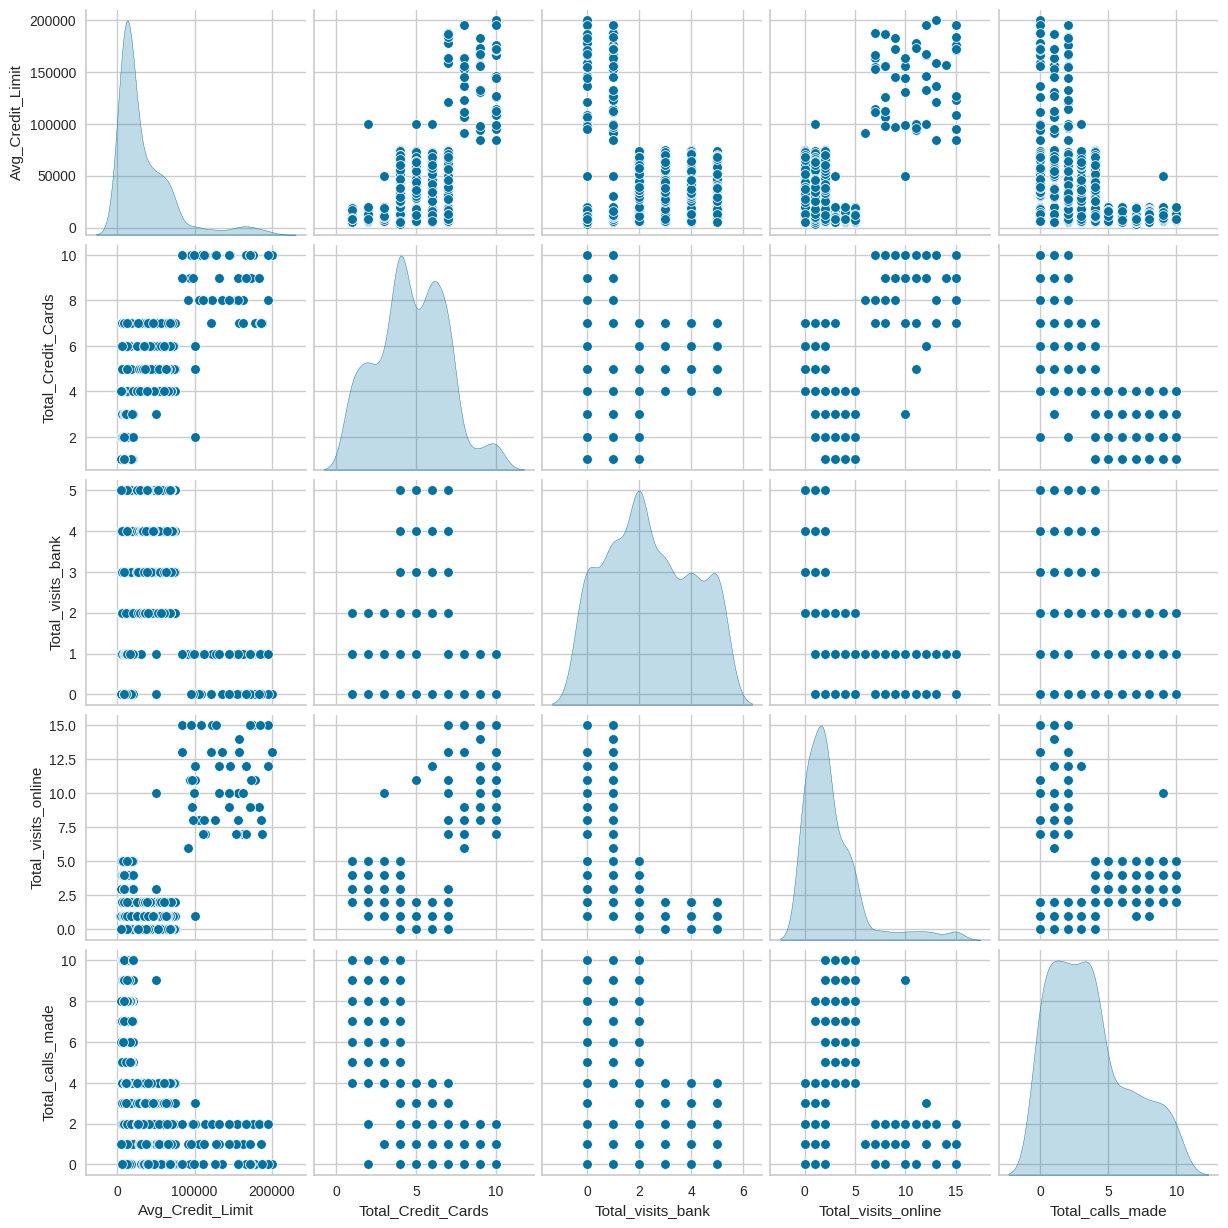

In [88]:
sns.pairplot(data=df, diag_kind="kde")
plt.show()

* Looking at the diagonal of the pairplot, there are several variables with multiple peaks
* Total_Credit_Cards variable seem to suggest that there are 4 potential clusters
* Total_visits_bank suggest that there are six possible clusters

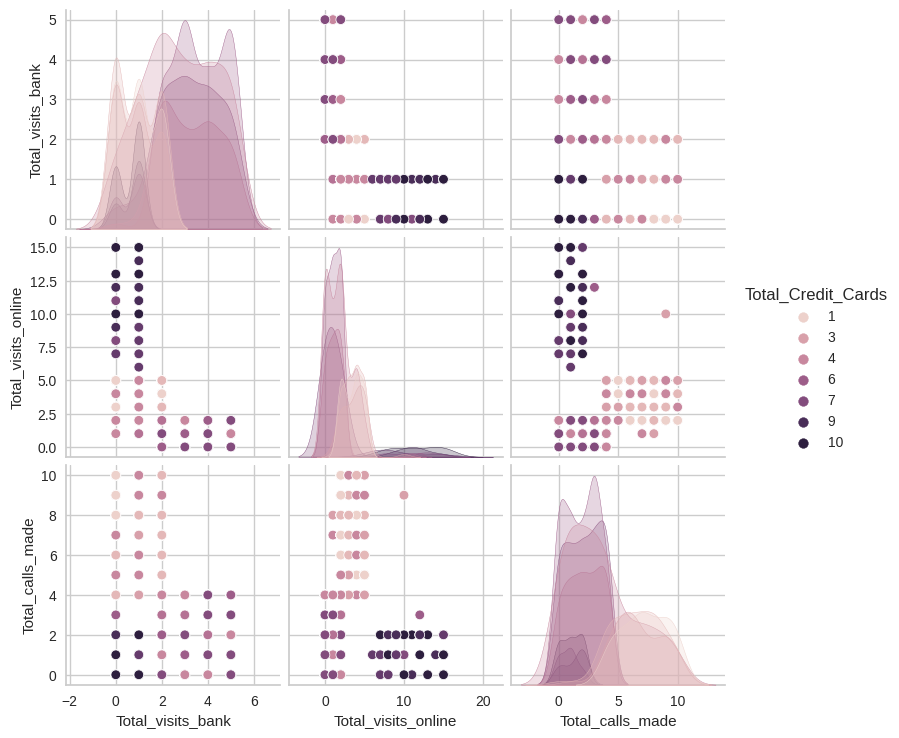

In [89]:
sns.pairplot(
    data=df[
        [
            "Total_visits_bank",
            "Total_visits_online",
            "Total_calls_made",
            "Total_Credit_Cards",
        ]
    ],
    hue="Total_Credit_Cards",
)

plt.show()

* Customers with large number of credit cards tend to use bank's online services more often than other customers.
* Customers with 1-3 credit cards make the most service related phone calls to the bank
* There are multiple peaks in the data on the diagonal of the pair plot, this suggest that we might have a large number of clusters (12 -13)

## Data Preprocessing



- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

#### Outlier Check

In [90]:
threshold = 3
outlier = {}
for col in df.columns:
    i = df[col]
    mean = np.mean(df[col])
    std = np.std(df[col])
    list1 = []
    for v in i:
        z = (v - mean) / std
        if z > threshold:
            list1.append(v)
    list1.sort()
    outlier[i.name] = list1

print("The following are the outliers in the data:")
for key, value in outlier.items():
    print("\n", key, ":", value)

The following are the outliers in the data:

 Avg_Credit_Limit : [153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 187000, 195000, 195000, 200000]

 Total_Credit_Cards : []

 Total_visits_bank : []

 Total_visits_online : [12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

 Total_calls_made : []


* Customers with credit limit of 153K or more are outliers
* Customers who made 12 or more online visits a year are outliers

#### Data Scaling

In [91]:
sc = StandardScaler()
scaled_df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)
scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## EDA

- It is a good idea to explore the data once again after manipulating it.

In [92]:
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,8.612639e-17,1.000758,-0.839808,-0.653623,-0.440840,0.357097,4.399975
Total_Credit_Cards,660.0,4.306320e-17,1.000758,-1.710864,-0.787585,0.135694,0.597334,2.443892
Total_visits_bank,660.0,-4.306320e-17,1.000758,-1.473731,-0.860451,-0.247170,0.979390,1.592670
Total_visits_online,660.0,7.536059e-17,1.000758,-0.888380,-0.547490,-0.206600,0.475180,4.224968
Total_calls_made,660.0,-8.612639e-17,1.000758,-1.251537,-0.902271,-0.203739,0.494794,2.241125


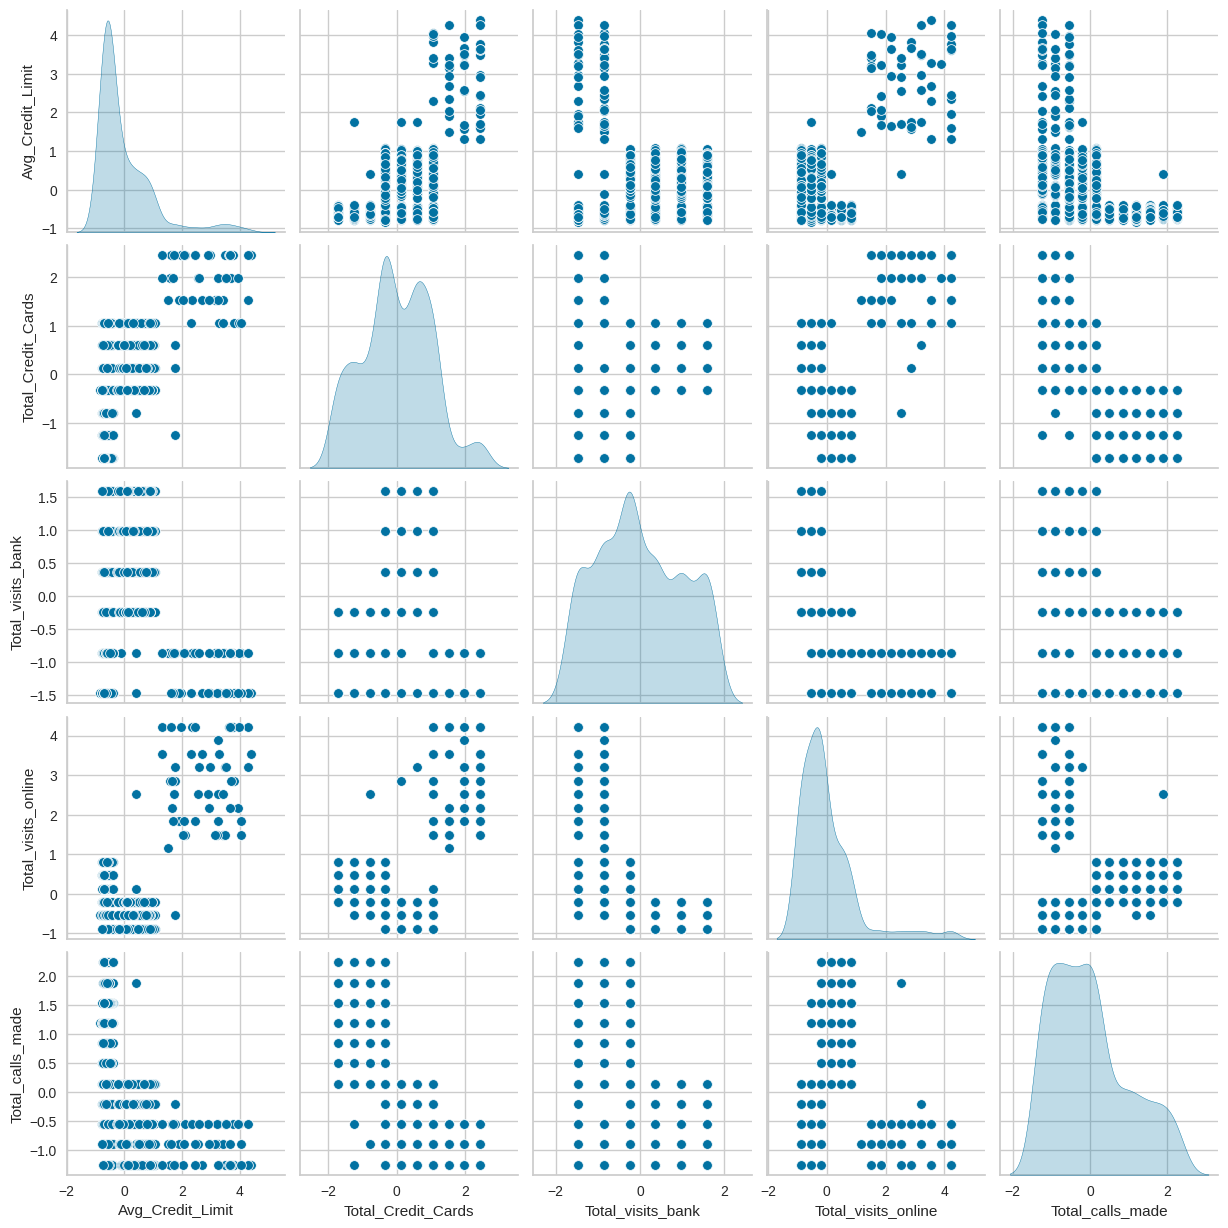

In [93]:
sns.pairplot(data=scaled_df, diag_kind="kde")
plt.show()

* No surprises after scaling - relationship between variables stayed the same, mean and standard deviation are 0 and 1 with some roundoff error.

## K-means Clustering

In [94]:
k_means_df = scaled_df.copy()

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.942639446557584
Number of Clusters: 7 	Average Distortion: 0.9229668941349187
Number of Clusters: 8 	Average Distortion: 0.8933022049325071
Number of Clusters: 9 	Average Distortion: 0.8701400217630185
Number of Clusters: 10 	Average Distortion: 0.8431371985874503
Number of Clusters: 11 	Average Distortion: 0.816337553276165


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

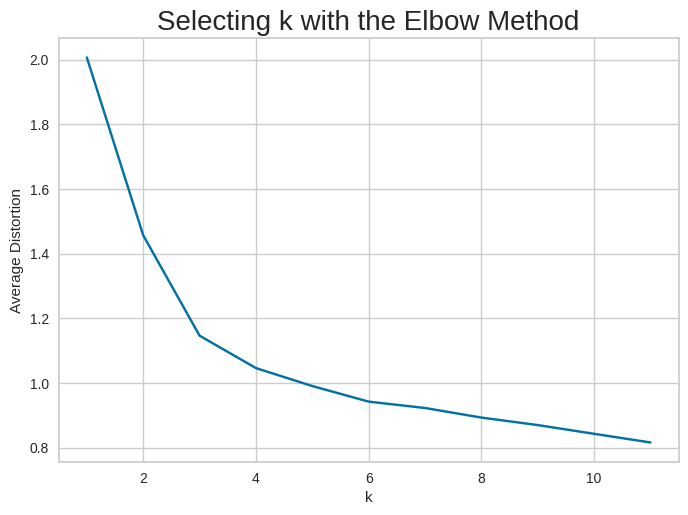

In [95]:
clusters = range(1, 12)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(scaled_df)  # Fit kMeans on the data
    prediction = model.predict(scaled_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(scaled_df, model.cluster_centers_, "euclidean"), axis=1))
        / scaled_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

* There is an elbow at k=3 and and possibly at k=4

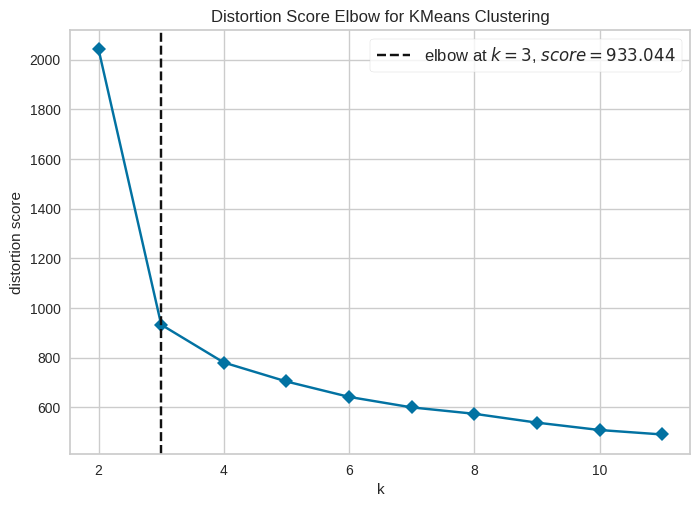

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 12), timings=False, distance_metric='euclidean')
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

* According to KElbowVisualizer k=3 is the best number of clusters for this data set
* Since the data contains outliers in two columns, I have tried using manhattan distance. It produced very similar results - obvious elbow at k = 3. Overall graphs looked nearly identical. I have not included them here because of how similar they look.
* Since manhattan distance doesn't change the number of clusters, we will just use the eucledian measure going forward.

#### Silhouette Scores

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.25545029453623114
For n_clusters = 7, silhouette score is 0.24836255872805713
For n_clusters = 8, silhouette score is 0.2253913269356253
For n_clusters = 9, silhouette score is 0.21739734269968086


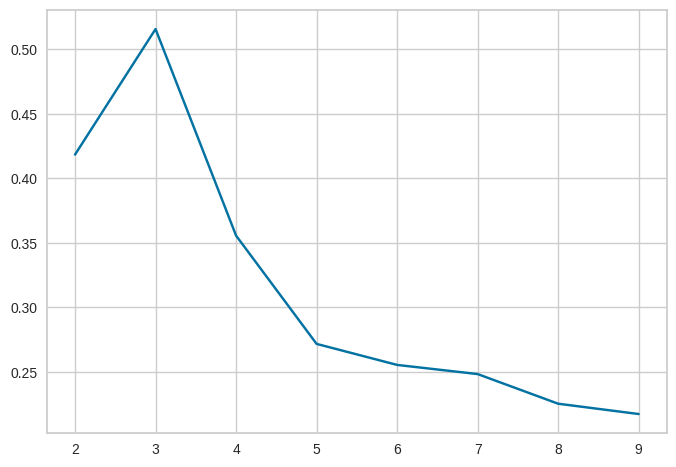

In [97]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((scaled_df))  # Predicting on the data
    score = silhouette_score(scaled_df, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

* The highest silhouette score is at k=3, followed by k=2, and k=4
* Let's visualize silhouettes for these values of k

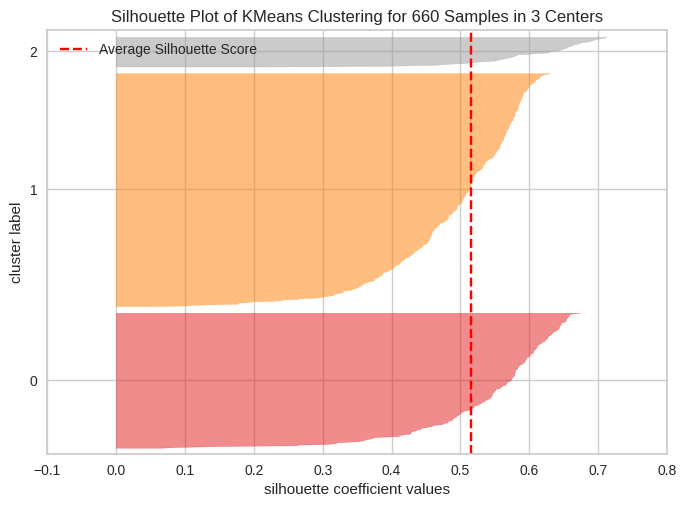

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [98]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

* All clusters have crossed Average silhouette score, all clusters have different width sizes, silhouette score is acceptable. Seems like k=3 is a good choice for number of clusters.

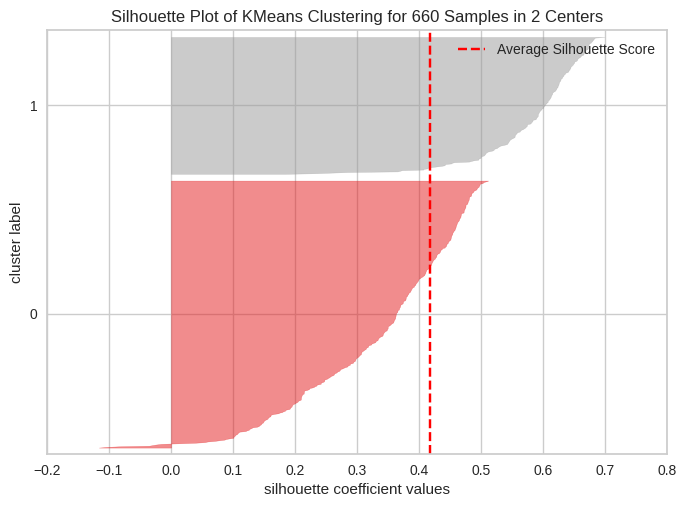

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [99]:
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

* k=2 is not a good choice, since there are negative silhouette scores in one of the clusters

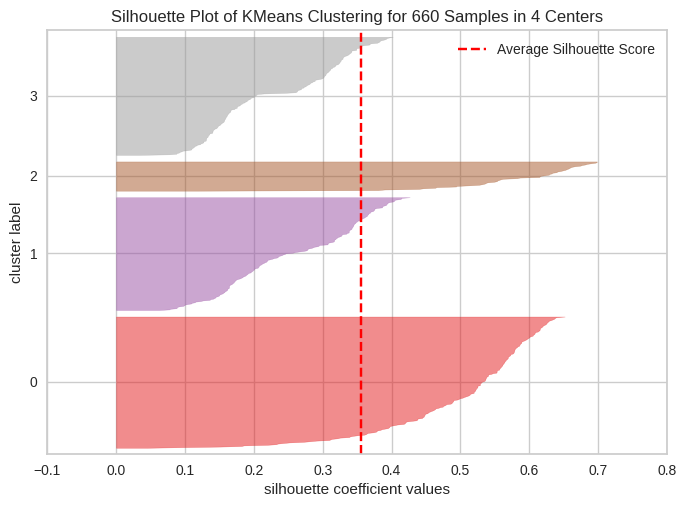

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [100]:
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

* at k=4 silhouette scores for clusters 1 and 3 are quite a bit a smaller than what we had for k=3. Also, clusters 1 and 3 are very similar in size, so k=4 is not a good number of clusters.
* We will go with k=3

### Applying KMeans clustering for k=3

In [101]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(scaled_df)

KMeans(n_clusters=3, random_state=0)

In [102]:
# adding kmeans cluster labels to the original and scaled dataframe
k_means_df["K_means_segments"] = kmeans.labels_

df1 = df.copy()
df1["K_means_segments"] = kmeans.labels_

### Cluster Profiling

In [103]:
km_cluster_profile = df1.groupby("K_means_segments").mean()

In [104]:
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [105]:
# let's display cluster profiles
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [106]:
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

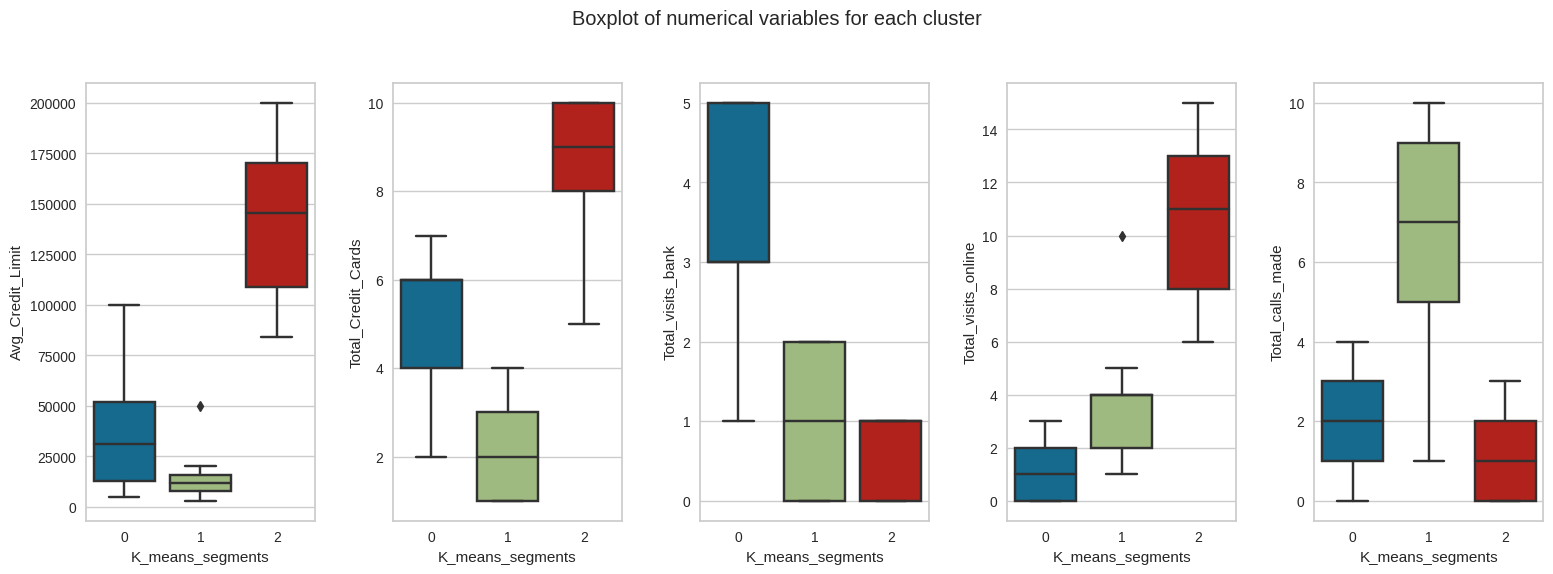

In [107]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
cols = ["Avg_Credit_Limit", "Total_Credit_Cards",	"Total_visits_bank",	"Total_visits_online",	"Total_calls_made"]
counter = 0
for ii in range(n):
    sns.boxplot(ax=axes[ii], y=df1[cols[counter]], x=df1["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<Axes: xlabel='K_means_segments'>

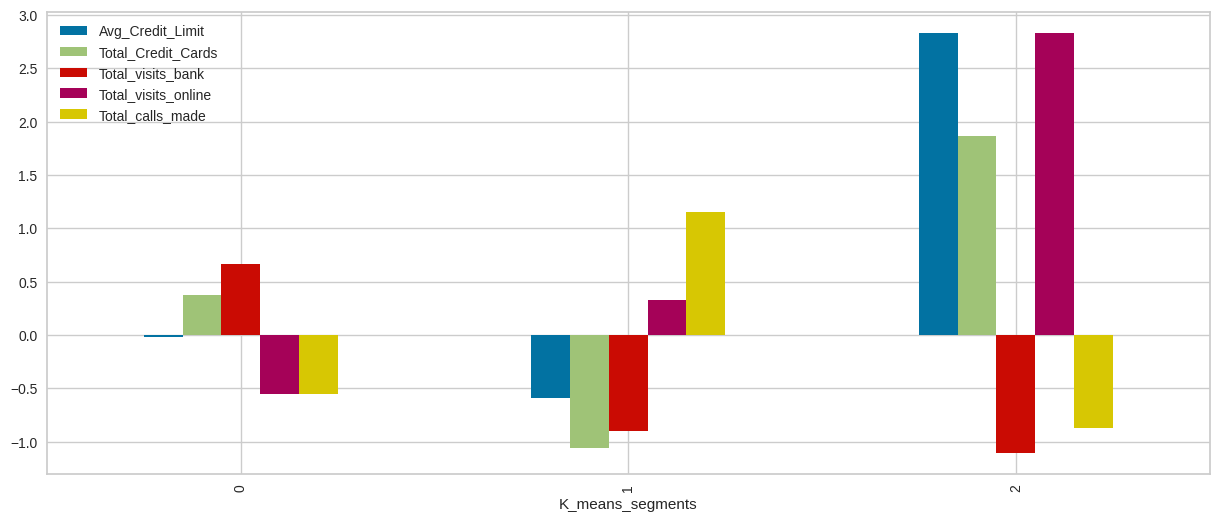

In [108]:
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

### Insights

* Cluster 0:
  * This is the biggest cluster, with 386 customers falling in this category.
  * This cluster contains customers with medium credit limit, 50% of the customers here have credit limit between 12K and 50K
  * 50% of the customers in the cluster have 4-6 credit cards.
  * These customers have the highest number of in-person bank visits
  * Lowest online usage of the three clusters
* Cluster 1:
  * This cluster contains 224 customers
  * This cluster contains customers with the smallest credit limits, typical credit limits are about 12k
  * 50% of these customers have one or two credit cards
  * These customers prefer to communicate with the bank over the phone
* Cluster 2:
  * This is the smallest cluster, containing only 50 customers
  * This cluster contains customers with large credit lines, with average credit limit of about 150K.
  * These customers tend to have more credit cards, with 75% of customers in this cluster have 8-10 credit cards.
  * This customers have high utilization of online services, and have the least number of calls or in-person visits.


## Hierarchical Clustering

In [109]:
hc_df = scaled_df.copy()

#### Cophenetic correlation

In [110]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875359.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [111]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


* Lets consider different linkage methods with Euclidean distance. We will use two additional linkage methods - Centroid, and Ward.

In [112]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [113]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


* Highest cophenetic correlation is obtained with Eucledian distance with average linkage
* Chebyshev distance and average linkage, and Cityblock distance and average linkage give very comparable results

#### Dendrograms with different linkage methods

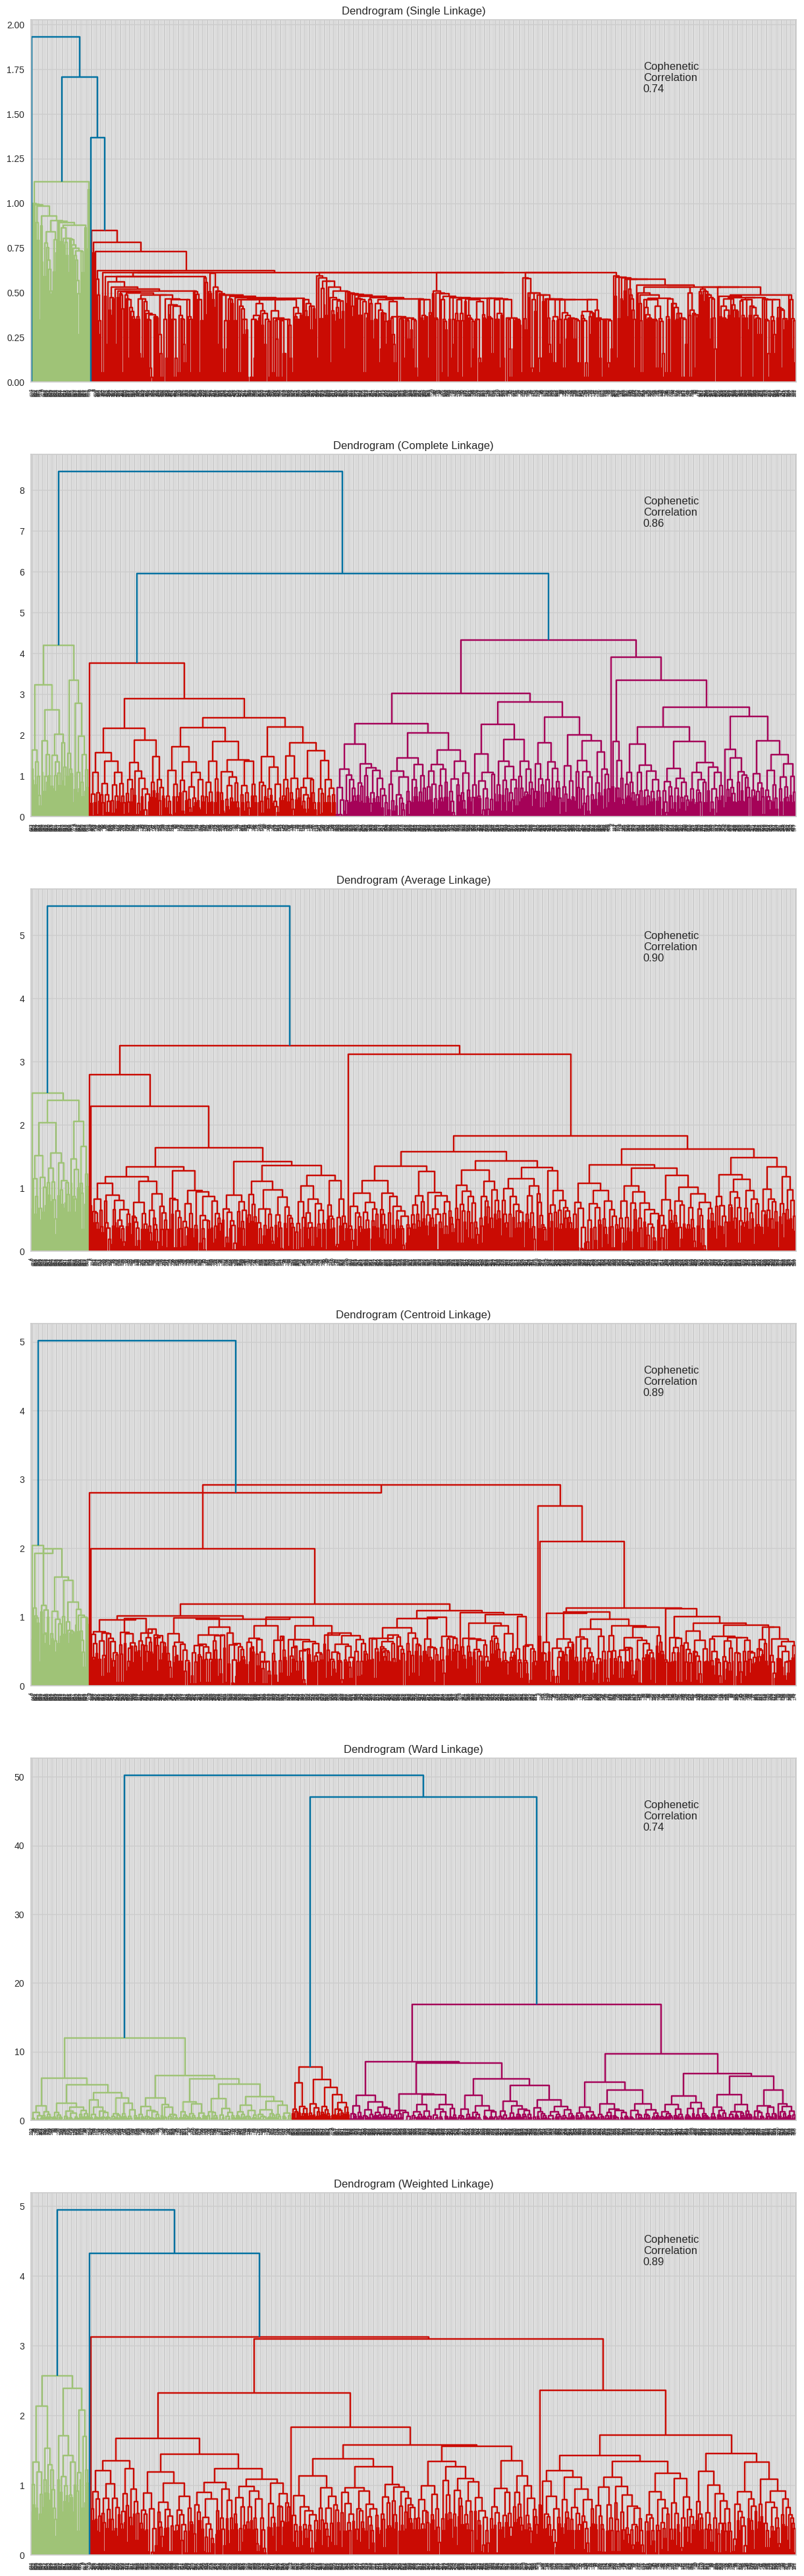

In [114]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 50))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

* The cophenetic correlation is highest for average linkage method.
* 3 appears to be the appropriate number of clusters from the dendogram for Average linkage.
* Let's visualize dendogram with three clusters

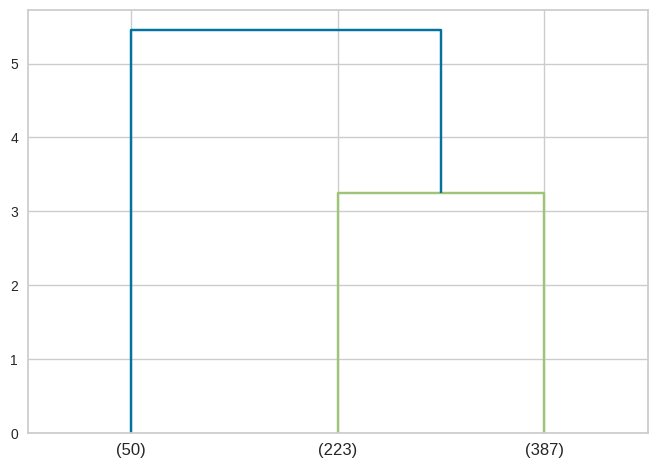

In [115]:
Z = linkage(scaled_df, metric="euclidean", method='average')
dendrogram(Z,truncate_mode='lastp',p=3)
plt.show()

#### Final Model

In [116]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=3)

In [117]:
# creating a copy of the original data
df2 = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

In [118]:
hc_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1


In [119]:
df2.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1
5,20000,3,0,1,8,2
6,100000,5,0,11,2,1
7,15000,3,0,1,1,2
8,5000,2,0,2,2,2
9,3000,4,0,1,7,2


## Cluster Profiling and Comparison

In [120]:
hc_cluster_profile = df2.groupby("HC_segments").mean()

In [121]:
hc_cluster_profile["count_in_each_segments"] = (
    df2.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

In [122]:
# lets display cluster profile
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


* The label assignments is different from K-means clustering
* Let's relabel the df2 and hc_df for ease of comparison

In [123]:
hc_df.loc[hc_df["HC_segments"] == 1, "HC_segments"] = 3
hc_df.loc[hc_df["HC_segments"] == 2, "HC_segments"] = 1
hc_df.loc[hc_df["HC_segments"] == 3, "HC_segments"] = 2

In [124]:
df2.loc[df2["HC_segments"] == 1, "HC_segments"] = 3
df2.loc[df2["HC_segments"] == 2, "HC_segments"] = 1
df2.loc[df2["HC_segments"] == 3, "HC_segments"] = 2

In [125]:
hc_cluster_profile = df2.groupby("HC_segments").mean()

In [126]:
hc_cluster_profile["count_in_each_segments"] = (
    df2.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

In [127]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [128]:
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,12197.309417,2.403587,0.928251,3.560538,6.883408,223
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


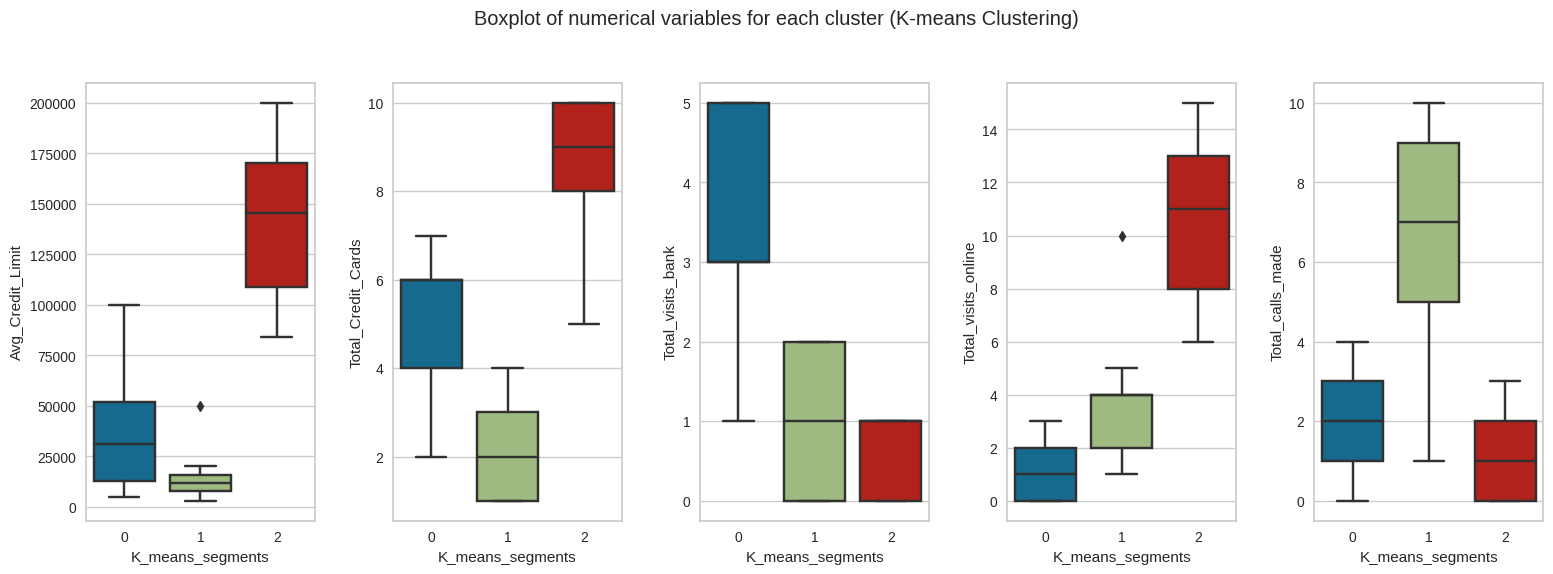

In [129]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster (K-means Clustering)")
cols = ["Avg_Credit_Limit", "Total_Credit_Cards",	"Total_visits_bank",	"Total_visits_online",	"Total_calls_made"]
counter = 0
for ii in range(n):
    sns.boxplot(ax=axes[ii], y=df1[cols[counter]], x=df1["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

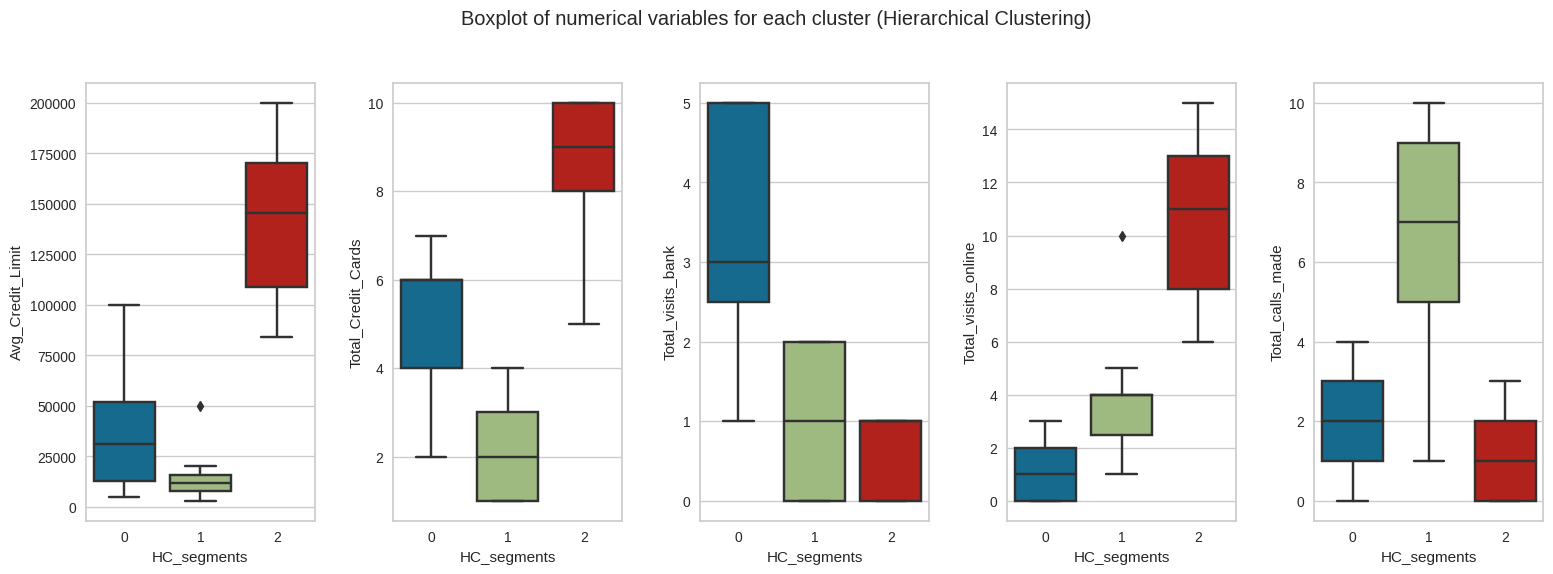

In [130]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster (Hierarchical Clustering)")
cols = ["Avg_Credit_Limit", "Total_Credit_Cards",	"Total_visits_bank",	"Total_visits_online",	"Total_calls_made"]
counter = 0
for ii in range(n):
    sns.boxplot(ax=axes[ii], y=df2[cols[counter]], x=df2["HC_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<Axes: xlabel='HC_segments'>

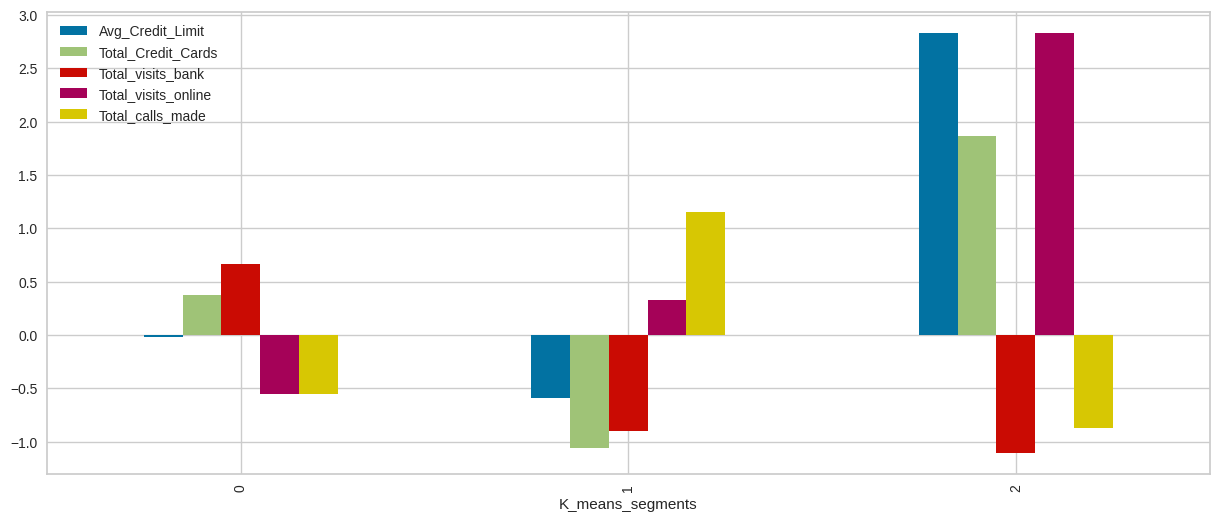

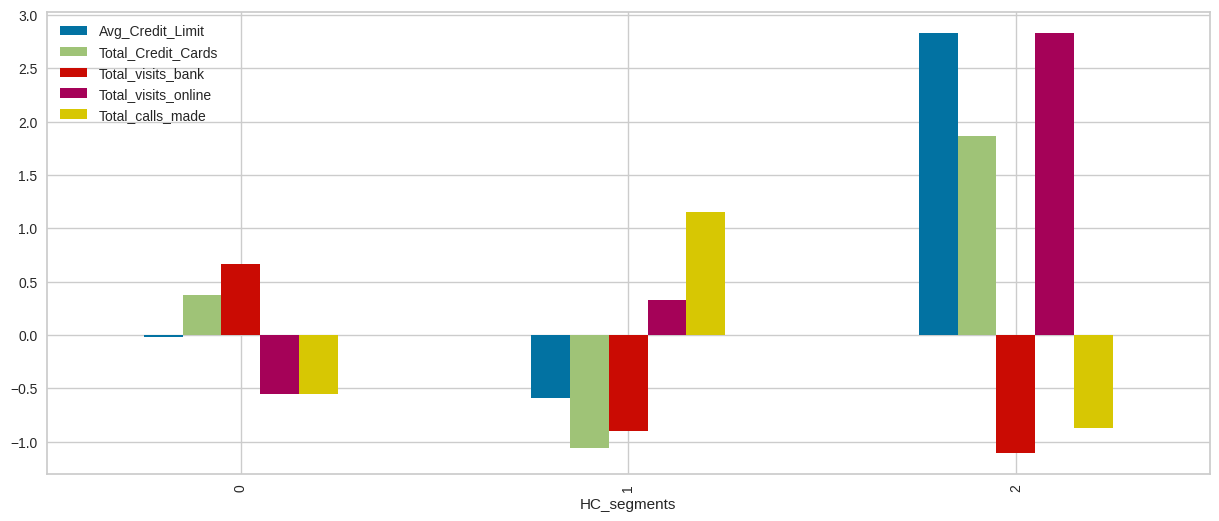

In [131]:
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))
hc_df.groupby("HC_segments").mean().plot.bar(figsize=(15, 6))

* The two techniques - K-means and Hierarchical Clustering produced the same number of clusters
* Clusters obtained from two algorithms are nearly identical.
* HC assigned one additional customer to the cluster 0, and one less customer to the cluster 1, but this difference is negligible.
* Computationally it seems that HC clustering took a bit more time, but the difference wasn't too bad, probably because the dataset is quite small.

## Actionable Insights and Recommendations

* Cluster 0: This cluster has the highest number of in-person bank visits and the lowest online usage. To cater to this group, banks can offer personalized services such as face-to-face meetings with financial advisors, in-person seminars, and workshops. Banks can also consider offering incentives such as cashback or discounts on transactions made in person.

* Cluster 1: This cluster has the smallest credit limits and prefers to communicate with the bank over the phone. Banks can offer personalized services such as dedicated phone lines for customer support, financial advice over the phone, and customized payment plans that suit their budget.

* Cluster 2: This cluster has a large credit limit and high utilization of online services. Banks can offer personalized services such as online financial advice, customized investment plans, and exclusive offers on premium credit cards. Banks can also consider offering incentives such as cashback or discounts on online transactions.

___

In [135]:
%%shell
jupyter nbconvert --to html '/content/Full_Code_AIML_USL_Project_CreditCardCustomerSegmentation (1).ipynb'


[NbConvertApp] Converting notebook /content/Full_Code_AIML_USL_Project_CreditCardCustomerSegmentation (1).ipynb to html
[NbConvertApp] Writing 2969553 bytes to /content/Full_Code_AIML_USL_Project_CreditCardCustomerSegmentation (1).html
